Normal Gravity with Competing Sweet Spots


/var/folders/_3/bg4ltz5x7nx864wk66d7w3sr0000gn/T/ipykernel_20503/839844784.py:117: DeprecationWarning: The time module and all its Schedulers are deprecated and will be removed in Mesa 3.1. They can be replaced with AgentSet functionality. See the migration guide for details. https://mesa.readthedocs.io/latest/migration_guide.html#time-and-schedulers
  self.schedule = RandomActivation(self)  # This is fine


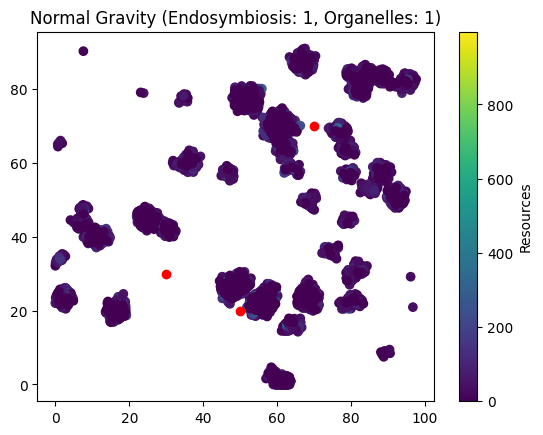

Endosymbiosis Events: 1, Organelle Agents: 1, Avg Resources: 102.82, Avg Motility: 1.01, Avg Efficiency: 1.25, Population: 13857, Positive Tropism Ratio: 0.35, Avg Tropism Strength: 0.50

Microgravity


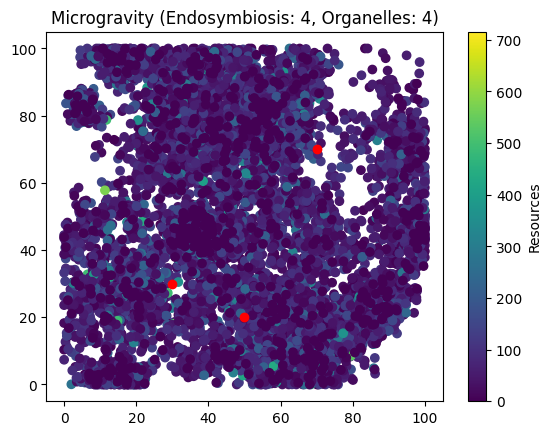

Endosymbiosis Events: 4, Organelle Agents: 4, Avg Resources: 76.83, Avg Motility: 1.08, Avg Efficiency: 1.25, Population: 10275, Positive Tropism Ratio: 0.65, Avg Tropism Strength: 0.50


In [7]:
import numpy as np
from mesa import Agent, Model
from mesa.space import ContinuousSpace
import matplotlib.pyplot as plt
import random

# Gravitational centers (position, strength) for sweet spots
GRAVITY_CENTERS = [
    (np.array([30, 30]), 1.0),  # Strongest
    (np.array([70, 70]), 0.7),  # Medium
    (np.array([50, 20]), 0.5)   # Weakest
]
G_NORMAL = 0.1  # Scaled gravitational constant
G_MICRO = 0     # Microgravity

class Tropism:
    def __init__(self, type="positive", strength=0.5, threshold=0.1, evolvable=True):
        self.type = type          # "positive" or "negative"
        self.strength = strength  # [0, 1]: Influence of gravity on movement
        self.threshold = threshold  # Minimum force to trigger response
        self.evolvable = evolvable  # Can it mutate?

    def mutate(self):
        if self.evolvable:
            self.strength = max(0, min(1, self.strength + np.random.uniform(-0.1, 0.1)))
            self.threshold = max(0, min(1, self.threshold + np.random.uniform(-0.05, 0.05)))

class PreyAgent:
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.resources = 5  # Resources provided when consumed or engulfed
        self.pos = None

    def step(self):
        if self.model.G != G_MICRO:
            nearest_pos, strength = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * strength * 0.05 / (r**2)
                direction = (nearest_pos - self.pos) / r
                vortex = np.array([-direction[1], direction[0]]) * 0.1
                self.pos += (direction * force + vortex) * 0.1
        self.pos = np.clip(self.pos, 0, 99.999)

class PredatorAgent:
    def __init__(self, unique_id, model):
        self.unique_id = unique_id
        self.model = model
        self.resources = 0
        self.motility = np.random.uniform(0.5, 1.5)  # Speed multiplier
        self.efficiency = np.random.uniform(0.5, 1.5)  # Resource use multiplier
        self.tropism = Tropism(type=random.choice(["positive", "negative"]), strength=0.5, threshold=0.1)
        self.has_organelle = False
        self.time_factor = 1.0  # Base time dilation
        self.pos = None

    def step(self):
        # Time dilation: Slower near strong gravity
        if self.model.G != G_MICRO:
            nearest_pos, grav_strength = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                self.time_factor = 1.0 / (1 + self.model.G * grav_strength / (r**2))  # Simplified dilation

        # Movement with tropism
        if self.model.G != G_MICRO and random.random() < self.time_factor:
            nearest_pos, grav_strength = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
            r = np.linalg.norm(self.pos - nearest_pos)
            if r > 0:
                force = self.model.G * grav_strength / (r**2)
                if force > self.tropism.threshold:
                    direction = (nearest_pos - self.pos) / r if self.tropism.type == "positive" else (self.pos - nearest_pos) / r
                    tropism_vector = direction * force * self.tropism.strength * self.motility
                    self.pos += tropism_vector * 0.1
        else:
            self.pos += np.random.uniform(-1.0, 1.0, 2) * self.motility * self.time_factor

        # Resource consumption
        nearest_pos, _ = min(GRAVITY_CENTERS, key=lambda m: np.linalg.norm(self.pos - m[0]))
        r = np.linalg.norm(self.pos - nearest_pos)
        resource_density = max(0, 10 - r / 5) if self.model.G != G_MICRO else 5  # Lower in microgravity
        self.resources += resource_density * self.efficiency * self.time_factor

        # Endosymbiosis: More likely near sweet spots
        neighbors = self.model.space.get_neighbors(self.pos, 2, include_center=False)
        for neighbor in neighbors:
            if isinstance(neighbor, PreyAgent) and not self.has_organelle and random.random() < (1 - r / 10):
                self.has_organelle = True
                self.resources += neighbor.resources
                self.efficiency *= 1.5
                self.model.space.remove_agent(neighbor)
                self.model.schedule.remove(neighbor)
                self.model.endosymbiosis_events += 1
                break

        # Reproduction
        if self.resources > 50 and random.random() < 0.1 * self.time_factor:
            offspring = PredatorAgent(self.model.next_id(), self.model)
            offspring.motility = self.motility + np.random.uniform(-0.1, 0.1)
            offspring.efficiency = self.efficiency + np.random.uniform(-0.1, 0.1)
            offspring.tropism = Tropism(self.tropism.type, self.tropism.strength, self.tropism.threshold)
            offspring.tropism.mutate()
            desired_pos = self.pos + np.random.uniform(-1, 1, 2)
            clipped_pos = np.clip(desired_pos, 0, 99.999)
            self.model.schedule.add(offspring)
            self.model.space.place_agent(offspring, clipped_pos)
            self.resources -= 25

        self.pos = np.clip(self.pos, 0, 99.999)

class GravityCompetitionModel(Model):
    def __init__(self, N_predators, N_prey, G):
        super().__init__()
        self.G = G
        self.space = ContinuousSpace(100, 100, torus=False)
        self.schedule = RandomActivation(self)  # This is fine
        self.endosymbiosis_events = 0
        self.next_id_val = N_predators + N_prey

        # Initialize predators
        for i in range(N_predators):
            agent = PredatorAgent(i, self)
            self.schedule.add(agent)
            initial_pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
            self.space.place_agent(agent, initial_pos)

        # Initialize prey
        for i in range(N_prey):
            prey = PreyAgent(N_predators + i, self)
            self.schedule.add(prey)
            initial_pos = np.array([np.random.uniform(0, 99.999), np.random.uniform(0, 99.999)])
            self.space.place_agent(prey, initial_pos)

    def next_id(self):
        self.next_id_val += 1
        return self.next_id_val - 1

    def step(self):
        # Remove the shuffle call - RandomActivation already handles randomness
        # self.schedule.shuffle()  # <- Remove this line
        self.schedule.step()  # Use step() instead of do("step")

def run_simulation(gravity, label, steps=100):
    model = GravityCompetitionModel(50, 50, gravity)
    for _ in range(steps):
        model.step()

    predators = [a for a in model.schedule.agents if isinstance(a, PredatorAgent)]
    positions = [a.pos for a in predators]
    x, y = zip(*positions)
    resources = [a.resources for a in predators]
    organelle_count = sum(1 for a in predators if a.has_organelle)
    avg_motility = np.mean([a.motility for a in predators])
    avg_efficiency = np.mean([a.efficiency for a in predators])
    tropism_types = [a.tropism.type for a in predators]
    avg_tropism_strength = np.mean([a.tropism.strength for a in predators])

    # Plot
    plt.scatter(x, y, c=resources, cmap="viridis")
    plt.colorbar(label="Resources")
    for pos, _ in GRAVITY_CENTERS:
        plt.plot(pos[0], pos[1], 'ro')
    plt.title(f"{label} (Endosymbiosis: {model.endosymbiosis_events}, Organelles: {organelle_count})")
    plt.show()

    return {
        "endosymbiosis_events": model.endosymbiosis_events,
        "organelle_agents": organelle_count,
        "avg_resources": np.mean(resources),
        "avg_motility": avg_motility,
        "avg_efficiency": avg_efficiency,
        "population": len(predators),
        "positive_tropism_ratio": tropism_types.count("positive") / len(tropism_types) if tropism_types else 0,
        "avg_tropism_strength": avg_tropism_strength
    }

# Run simulations
print("Normal Gravity with Competing Sweet Spots")
normal_results = run_simulation(G_NORMAL, "Normal Gravity")
print(f"Endosymbiosis Events: {normal_results['endosymbiosis_events']}, "
      f"Organelle Agents: {normal_results['organelle_agents']}, "
      f"Avg Resources: {normal_results['avg_resources']:.2f}, "
      f"Avg Motility: {normal_results['avg_motility']:.2f}, "
      f"Avg Efficiency: {normal_results['avg_efficiency']:.2f}, "
      f"Population: {normal_results['population']}, "
      f"Positive Tropism Ratio: {normal_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {normal_results['avg_tropism_strength']:.2f}")

print("\nMicrogravity")
micro_results = run_simulation(G_MICRO, "Microgravity")
print(f"Endosymbiosis Events: {micro_results['endosymbiosis_events']}, "
      f"Organelle Agents: {micro_results['organelle_agents']}, "
      f"Avg Resources: {micro_results['avg_resources']:.2f}, "
      f"Avg Motility: {micro_results['avg_motility']:.2f}, "
      f"Avg Efficiency: {micro_results['avg_efficiency']:.2f}, "
      f"Population: {micro_results['population']}, "
      f"Positive Tropism Ratio: {micro_results['positive_tropism_ratio']:.2f}, "
      f"Avg Tropism Strength: {micro_results['avg_tropism_strength']:.2f}")